In [61]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold

import pandas as pd
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns 

# seed 값 설정
seed=0
numpy.random.seed(3)
tf.random.set_seed(3)

In [40]:
# 데이터 불러오기
df = pd.read_csv('data/Automobile_customers.csv')
df.head()

,Customer ID,Age,Income_Bucket,Gender,State,Region,Marital_Status,No_of_children,Occupation,Vehicle_Segment,No_of_months,Hobbies,On_Call_Offer
0,46756841,28,2,M,Q,Sub-urban#,1,4,White Collar Clerical,SUV,39,Swimming,Plan 1
1,48408855,25,3,M,A,Sub-urban#,2,3,Engineer,Compact SUV,14,Painting,Plan 5
2,23645631,58,2,M,Z,Urban#,2,4,Defence,Car,24,Reading Books,Plan 5
3,65645152,37,1,M,W,Sub-urban#,2,4,Sales Executive,Pick up truck,27,Gourmet Cooking,Plan 4
4,52236057,64,2,M,S,Sub-urban,1,4,Chef,Pick up truck,56,Music,Plan 4


In [41]:
df.info()
#Gender, State, Region, Occupation, Vehicle_Segment, Hobbies, On_Call_Offer는 object 타입이므로 어떤 데이터인지 csv 파일로 직접 확인
#Gender는 성별 F,M,!M,MA 로 이루어짐. F만 여자 나머지는 남자
#State는 A~Z까지의 알파벳으로 이루어져 있으나 어떤 의미인지 알 수 없으므로 사용X
#Region 지역을 나타내는데 Urban, Sub-urban#, Urban%, rural 으로 이루어짐. #, %을 제거해줄것
#Occupation은 직업
#Vehicle_Segment는 차량 종류
#Hobbies는 취미
#On_Call_Offer는 예측할 내용인 가입한 구독 플랜

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10733 entries, 0 to 10732
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Customer ID      10733 non-null  int64 
 1   Age              10733 non-null  int64 
 2   Income_Bucket    10733 non-null  int64 
 3   Gender           10733 non-null  object
 4   State            10715 non-null  object
 5   Region           10733 non-null  object
 6   Marital_Status   10733 non-null  int64 
 7   No_of_children   10733 non-null  int64 
 8   Occupation       10733 non-null  object
 9   Vehicle_Segment  10733 non-null  object
 10  No_of_months     10733 non-null  int64 
 11  Hobbies          10733 non-null  object
 12  On_Call_Offer    10733 non-null  object
dtypes: int64(6), object(7)
memory usage: 1.1+ MB


In [42]:
#필요없는 데이터 삭제
df = df.drop(['Customer ID','State','Hobbies'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10733 entries, 0 to 10732
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Age              10733 non-null  int64 
 1   Income_Bucket    10733 non-null  int64 
 2   Gender           10733 non-null  object
 3   Region           10733 non-null  object
 4   Marital_Status   10733 non-null  int64 
 5   No_of_children   10733 non-null  int64 
 6   Occupation       10733 non-null  object
 7   Vehicle_Segment  10733 non-null  object
 8   No_of_months     10733 non-null  int64 
 9   On_Call_Offer    10733 non-null  object
dtypes: int64(5), object(5)
memory usage: 838.6+ KB


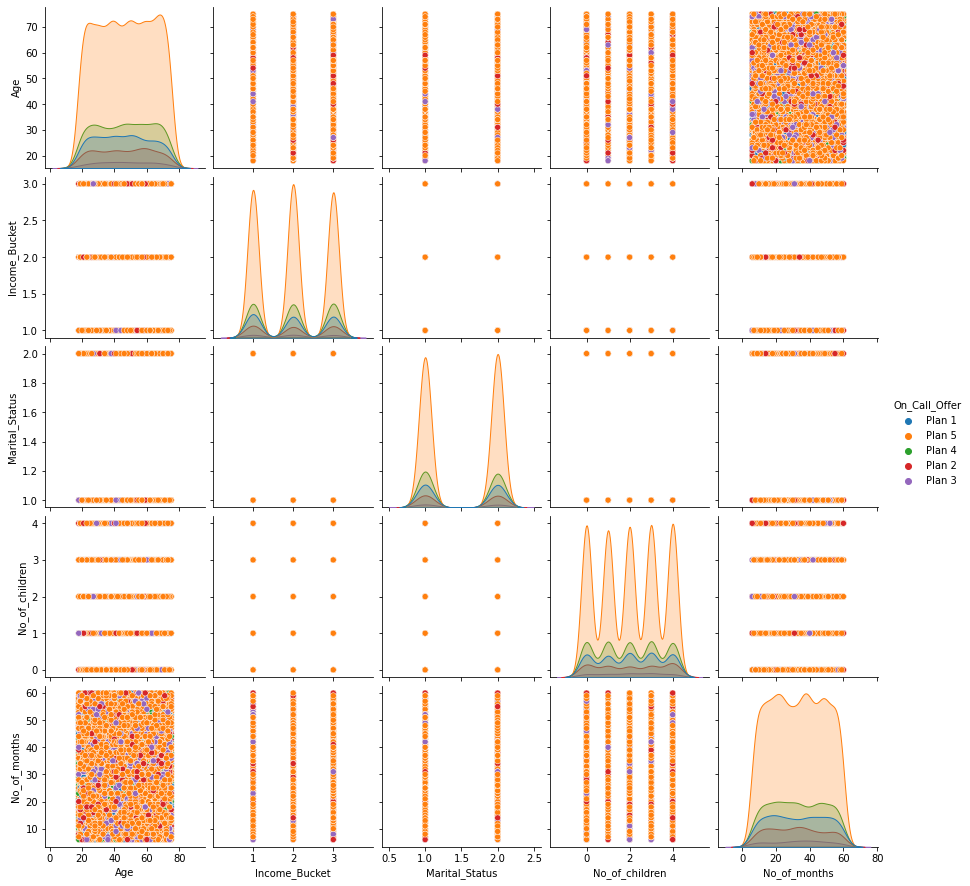

In [45]:
sns.pairplot(df, hue='On_Call_Offer')
plt.show()

In [46]:
#필요없는 데이터 삭제
#위의 그래프를 보면 값이 달라도 각 plan에 대한 비율이 대부분 비슷하거나 같기 때문에 필요없는 데이터라고 생각해 모두 제거
df = df.drop(['Age','Income_Bucket','Marital_Status','No_of_children', 'No_of_months'], axis=1)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10733 entries, 0 to 10732
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           10733 non-null  object
 1   Region           10733 non-null  object
 2   Occupation       10733 non-null  object
 3   Vehicle_Segment  10733 non-null  object
 4   On_Call_Offer    10733 non-null  object
dtypes: object(5)
memory usage: 419.4+ KB


In [48]:
#잘못된 데이터를 변경
df['Gender'] = df['Gender'].str.replace('!', '');
df['Gender'] = df['Gender'].str.replace('A', '');
df['Region'] = df['Region'].str.replace('%', '');
df['Region'] = df['Region'].str.replace('#', '');

In [49]:
def oneHotEncoding(df, column):
    dummy = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummy], axis=1)
    df = df.drop(column, axis=1)
    return df

In [50]:
#object 데이터들을 oneHotEncoding
categories = ['Gender', 'Region', 'Occupation', 'Vehicle_Segment']
for i in categories:
    df = oneHotEncoding(df,i)

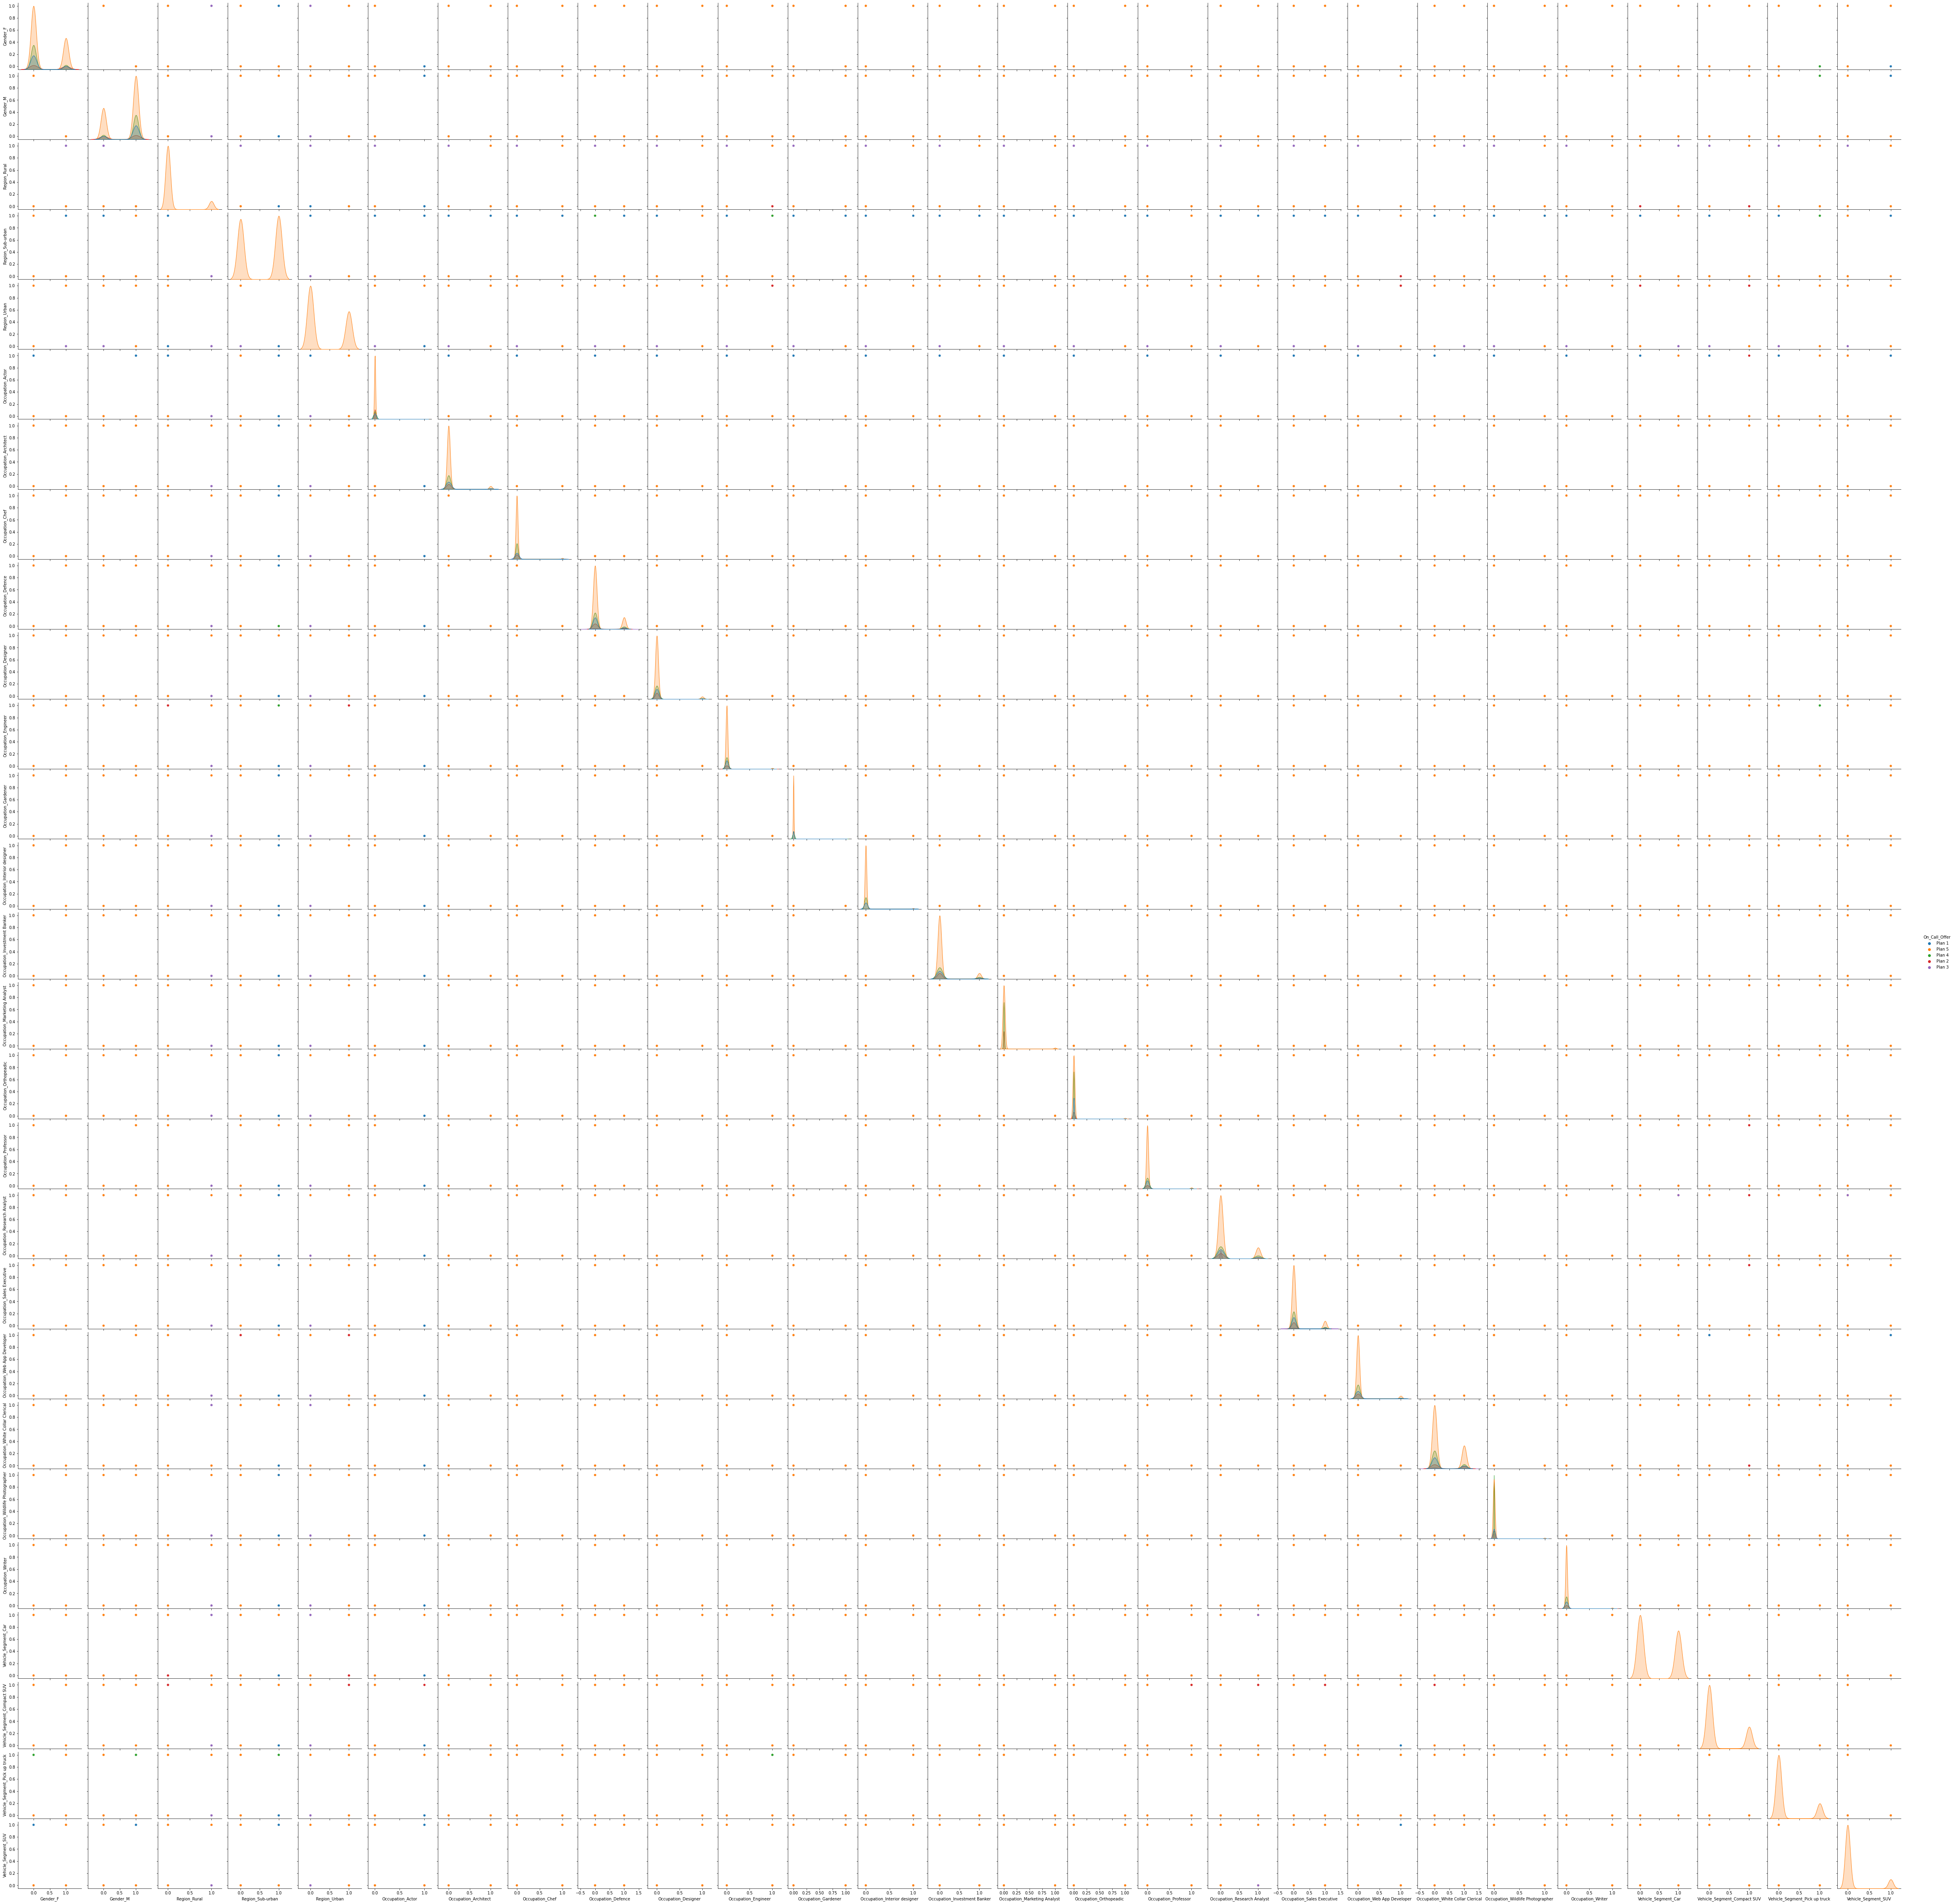

In [51]:
sns.pairplot(df, hue='On_Call_Offer')
plt.show()

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10733 entries, 0 to 10732
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   On_Call_Offer                     10733 non-null  object
 1   Gender_F                          10733 non-null  uint8 
 2   Gender_M                          10733 non-null  uint8 
 3   Region_Rural                      10733 non-null  uint8 
 4   Region_Sub-urban                  10733 non-null  uint8 
 5   Region_Urban                      10733 non-null  uint8 
 6   Occupation_Actor                  10733 non-null  uint8 
 7   Occupation_Architect              10733 non-null  uint8 
 8   Occupation_Chef                   10733 non-null  uint8 
 9   Occupation_Defence                10733 non-null  uint8 
 10  Occupation_Designer               10733 non-null  uint8 
 11  Occupation_Engineer               10733 non-null  uint8 
 12  Occupation_Gardene

In [53]:
X = df.drop(['On_Call_Offer'], axis=1).values
Y_obj = df['On_Call_Offer'].values

In [54]:
e = LabelEncoder()
e.fit(Y_obj)
Y = e.transform(Y_obj)

In [55]:
Y_encoded = np_utils.to_categorical(Y)

In [56]:
#훈련셋과 테스트셋 분리
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.3, random_state=seed)

In [73]:
model = Sequential()
model.add(Dense(16, input_dim=27, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [74]:
history = model.fit(X_train, Y_train, epochs = 5, validation_split=0.2, batch_size=32)

Train on 6010 samples, validate on 1503 samples
Epoch 1/5
6010/6010 [==============================] - 0s 61us/step - loss: 1.1970 - accuracy: 0.5842 - val_loss: 0.9079 - val_accuracy: 0.7359
Epoch 2/5
6010/6010 [==============================] - 0s 44us/step - loss: 0.6417 - accuracy: 0.8120 - val_loss: 0.4393 - val_accuracy: 0.8743
Epoch 3/5
6010/6010 [==============================] - 0s 44us/step - loss: 0.3002 - accuracy: 0.9409 - val_loss: 0.2194 - val_accuracy: 0.9741
Epoch 4/5
6010/6010 [==============================] - 0s 44us/step - loss: 0.1549 - accuracy: 0.9779 - val_loss: 0.1194 - val_accuracy: 0.9747
Epoch 5/5
6010/6010 [==============================] - 0s 44us/step - loss: 0.0882 - accuracy: 0.9839 - val_loss: 0.0715 - val_accuracy: 0.9834


<function matplotlib.pyplot.show(close=None, block=None)>

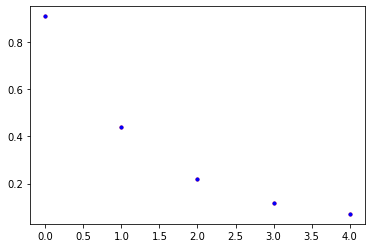

In [75]:
y_vloss = history.history['val_loss']

y_acc = history.history['accuracy']

x_len = numpy.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_vloss, "o", c="blue", markersize=3)
plt.show

In [70]:
print("\n Accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

3220/3220 [==============================] - 0s 24us/step

 Accuracy: 1.0000
